Time Series Forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_palette = sns.color_palette('bright')

In [ ]:
df = pd.read_csv("/content/AEP_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


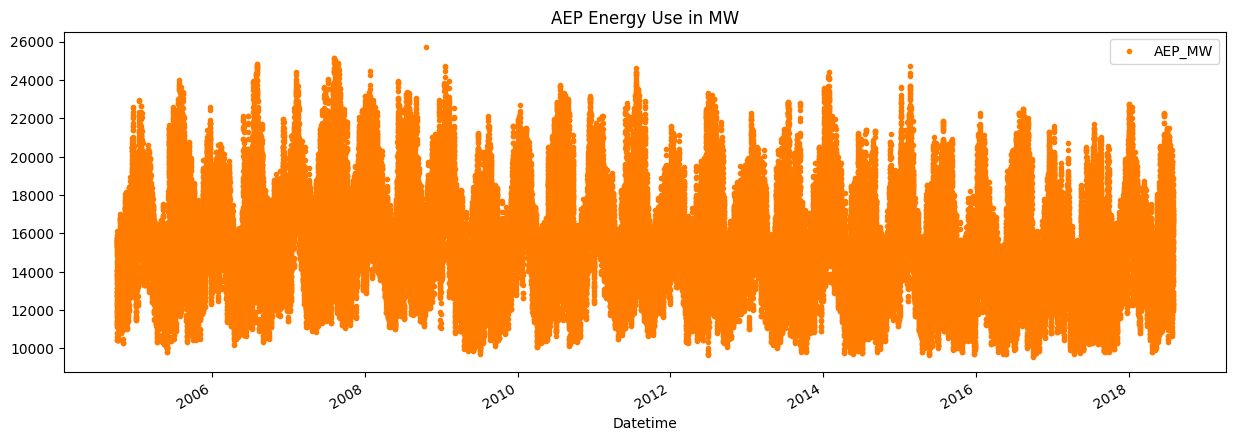

In [ ]:
df.plot(style='.',
        color = color_palette[1],
        figsize=(15,5),
        title="AEP Energy Use in MW",)
plt.show()

Train/Test Split

In [ ]:
train = df.loc[df.index <'2015-01-01']
test = df.loc[df.index >= '2015-01-01']

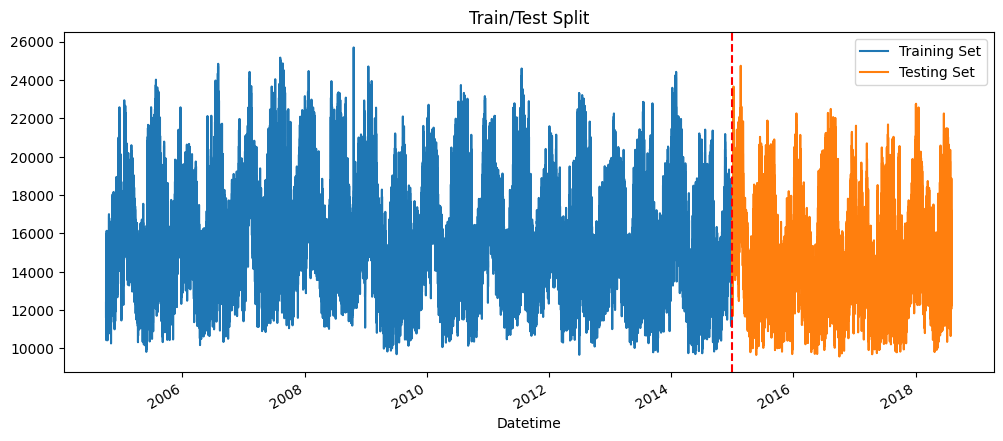

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Testing Set')
ax.axvline('2015-01-01', color='red', ls='--')
ax.legend(['Training Set', 'Testing Set'])
plt.title("Train/Test Split")
plt.show()

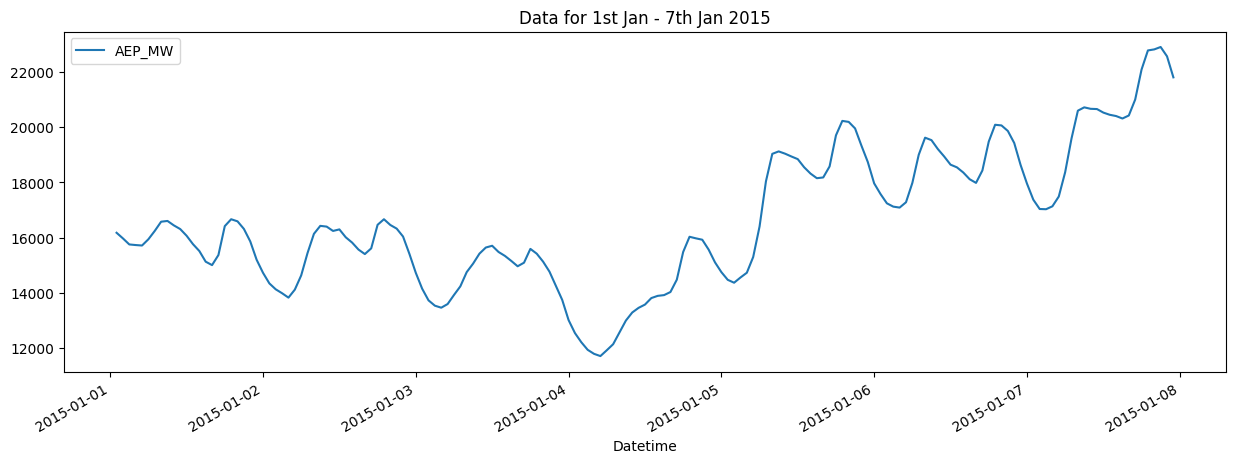

In [ ]:
one_week = df.loc[(df.index > '2015-01-01') & (df.index < '2015-01-08')]
one_week.plot( figsize=(15,5), title='Data for 1st Jan - 7th Jan 2015')
plt.show()

Features Extraction

In [ ]:
def feature_extraction(df):
  """
  Extracts time series features
  """
  df = df.copy()
  df['year'] = df.index.year
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['dayofweek'] = df.index.day_of_week
  df['dayofyear'] = df.index.day_of_year
  df['hour'] = df.index.hour
  return df
df = feature_extraction(df)
train = feature_extraction(train)
test = feature_extraction(test)

<ipython-input-66-cc7ab8e79147>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x ='hour', y='AEP_MW', palette='Blues')


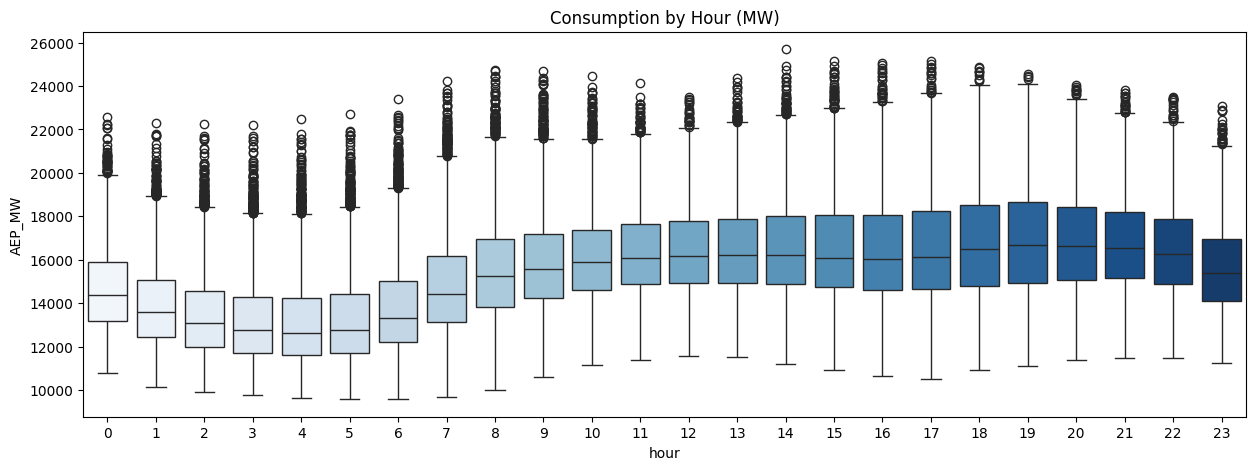

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x ='hour', y='AEP_MW', palette='Blues')
ax.set_title('Consumption by Hour (MW)')
plt.show()

<ipython-input-67-636613207620>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x ='month', y='AEP_MW', palette='Blues')


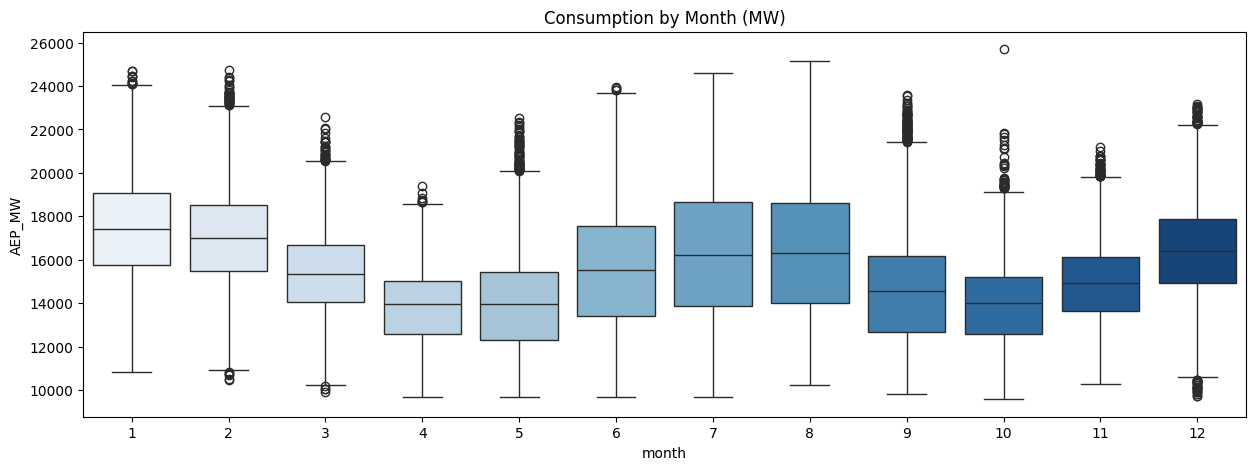

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x ='month', y='AEP_MW', palette='Blues')
ax.set_title('Consumption by Month (MW)')
plt.show()

In [ ]:
train.tail()

,AEP_MW,year,quarter,month,dayofweek,hour,dayofyear,minutes
Datetime,,,,,,,,
2014-01-01 20:00:00,16433.0,2014,1,1,2,20,1,0
2014-01-01 21:00:00,16376.0,2014,1,1,2,21,1,0
2014-01-01 22:00:00,16151.0,2014,1,1,2,22,1,0
2014-01-01 23:00:00,15687.0,2014,1,1,2,23,1,0
2014-01-02 00:00:00,15201.0,2014,1,1,3,0,2,0


In [ ]:
FEATURES = ['year', 'quarter', 'month', 'dayofyear', 'dayofweek', 'hour']
LABEL = ['AEP_MW']

X_train = train[FEATURES]
Y_train =  train[LABEL]

X_test = test[FEATURES]
Y_test = test[LABEL]

XGBoost Regressor Model

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, max_depth=6, max_leaves=35,
                       learning_rate=0.01, early_stopping_rounds=50)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=50)

[0]	validation_0-rmse:2559.09705	validation_1-rmse:2671.52904
[50]	validation_0-rmse:2047.28531	validation_1-rmse:2224.46629
[100]	validation_0-rmse:1761.26662	validation_1-rmse:1988.72783
[150]	validation_0-rmse:1581.76376	validation_1-rmse:1843.78466
[200]	validation_0-rmse:1467.98389	validation_1-rmse:1763.11317
[250]	validation_0-rmse:1392.65960	validation_1-rmse:1719.76877
[300]	validation_0-rmse:1338.27905	validation_1-rmse:1694.34861
[350]	validation_0-rmse:1284.79448	validation_1-rmse:1674.00185
[400]	validation_0-rmse:1246.06625	validation_1-rmse:1659.48976
[450]	validation_0-rmse:1214.75297	validation_1-rmse:1650.96198
[500]	validation_0-rmse:1190.92614	validation_1-rmse:1645.50984
[550]	validation_0-rmse:1170.60581	validation_1-rmse:1643.66132
[600]	validation_0-rmse:1158.30744	validation_1-rmse:1641.65146
[650]	validation_0-rmse:1145.61416	validation_1-rmse:1646.56917


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=35,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
fi = pd.DataFrame(reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns= ['Importance'])
fi.head()

,Importance
year,0.053504
quarter,0.121739
month,0.175145
dayofyear,0.129296
dayofweek,0.166959


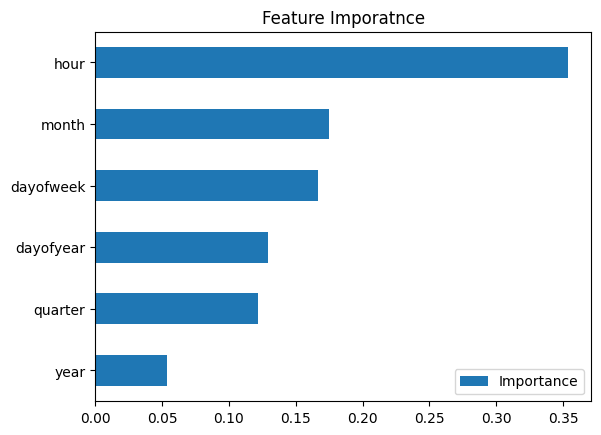

In [ ]:
fi.sort_values('Importance').plot(kind='barh', title='Feature Imporatnce')
plt.show()

Forecast on Test Set

In [ ]:
test['predictions'] = reg.predict(X_test)
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)
df.head()

,AEP_MW,year,quarter,month,dayofweek,hour,dayofyear,predictions
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,2004,4,10,4,1,275,NaN
2004-10-01 02:00:00,11935.0,2004,4,10,4,2,275,NaN
2004-10-01 03:00:00,11692.0,2004,4,10,4,3,275,NaN
2004-10-01 04:00:00,11597.0,2004,4,10,4,4,275,NaN
2004-10-01 05:00:00,11681.0,2004,4,10,4,5,275,NaN


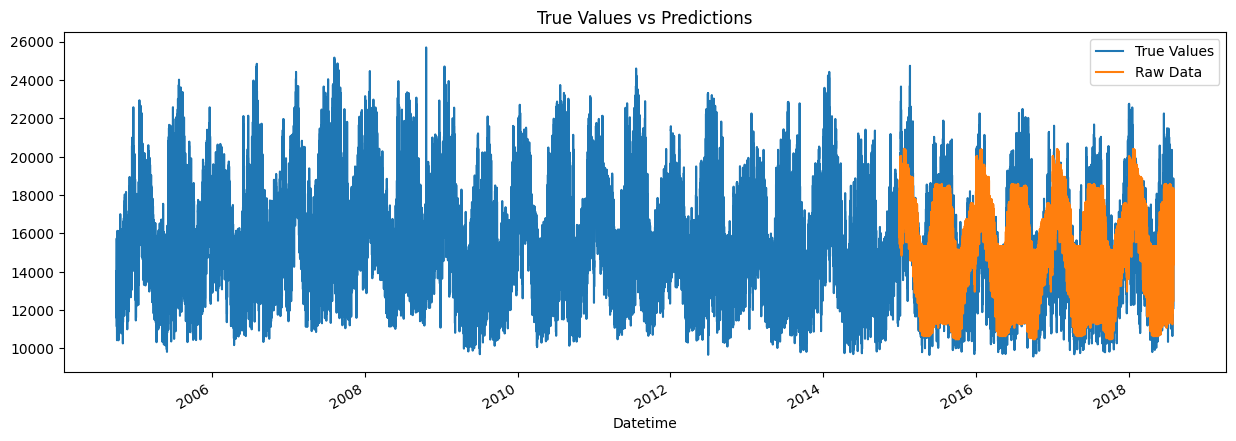

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df['AEP_MW'].plot(title='True Values vs Predictions')
test['predictions'].plot(ax=ax)
plt.legend(['True Values', 'Raw Data'])
plt.show()


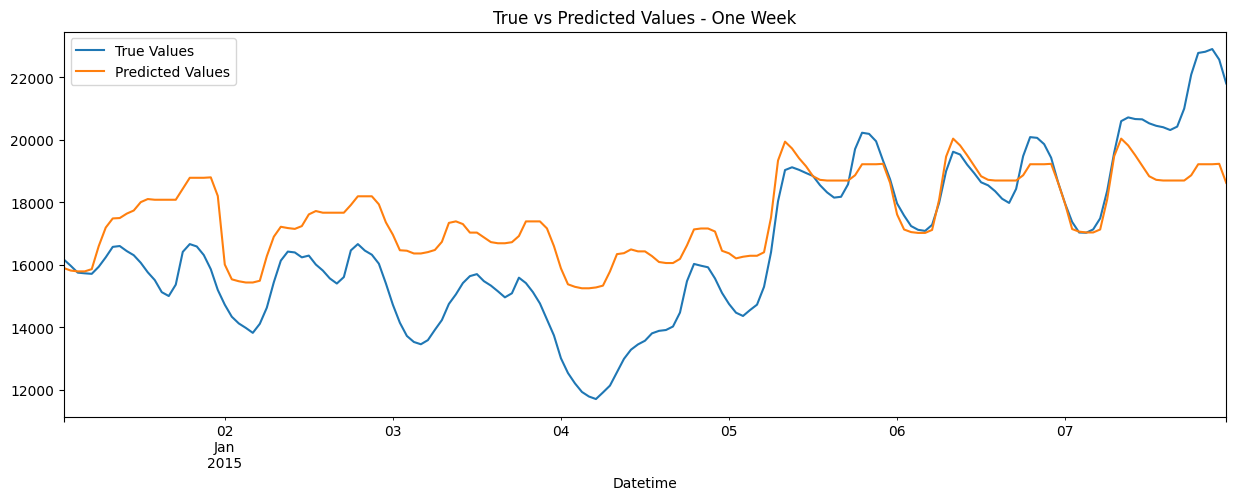

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df.loc[(df.index > '2015-01-01') & (df.index < '2015-01-08')]['AEP_MW'].plot()
df.loc[(df.index > '2015-01-01') & (df.index < '2015-01-08')]['predictions'].plot()
ax.set_title('True vs Predicted Values - One Week')
ax.legend(['True Values', 'Predicted Values'])
plt.show()

Metrics

In [ ]:
rmse = np.sqrt(mean_squared_error(test['AEP_MW'], test['predictions']))
print(f'The RMSE on the test set is: {rmse:0.2f}')

The RMSE on the test set is: 1641.65


In [ ]:
test.head()

,AEP_MW,year,quarter,month,dayofweek,hour,dayofyear,predictions,minutes,error,date
Datetime,,,,,,,,,,,
2015-01-01 00:00:00,16375.0,2015,1,1,3,0,1,16385.708984,0,10.708984,2015-01-01
2015-12-31 01:00:00,12415.0,2015,4,12,3,1,365,14646.598633,0,2231.598633,2015-12-31
2015-12-31 02:00:00,12087.0,2015,4,12,3,2,365,14475.511719,0,2388.511719,2015-12-31
2015-12-31 03:00:00,12010.0,2015,4,12,3,3,365,14411.597656,0,2401.597656,2015-12-31
2015-12-31 04:00:00,11972.0,2015,4,12,3,4,365,14411.597656,0,2439.597656,2015-12-31


In [ ]:
test['error'] = np.abs(test['AEP_MW'] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-01-22    4885.684692
2015-02-20    4820.160278
2015-02-19    4770.066243
2017-01-23    4369.360026
2018-01-22    4287.735026
2018-01-06    4228.445557
2017-02-07    4193.845947
2017-01-25    4137.020915
2017-01-03    4114.913900
2017-02-12    4035.079020
Name: error, dtype: float64